In [143]:
%matplotlib inline
#The libraries we are going to use are PySerial and Time
# PySerial is encapsulates the access for the serial port.
# 
import serial
import time
import numpy as np
# script that allow to set the graphs for the signal
#from graph import *
# Matplotlib to draw functions
import matplotlib.pyplot as plt
# To allow make live data graph we need drawnow
# pip install drawnow
from drawnow import *
from IPython import display

In [5]:
# Opening a Serial port

# - The port is immediately opened on object creation, when a port is given. It is not opened when
# port is None and a successive call to open() is required. port is a device name: depending on 
# operating system. e.g. /dev/ttyUSB0 on GNU/Linux or COM3 on Windows.
# - The parameter baudrate can be one of the standard values:  50, 75, 110, 134, 150, 200, 300, 600, 1200,
# 1800, 2400, 4800, 9600, 19200, 38400, 57600, 115200. These are well supported on all platforms.
# - Standard values above 115200, such as:  230400, 460800, 500000, 576000, 921600, 1000000, 1152000,
# 1500000, 2000000, 2500000, 3000000, 3500000, 4000000 also work on many platforms and devices.
# Non-standard values are also supported on some platforms (GNU/Linux, MAC OSX >= Tiger, Windows).
# - Possible values for the parameter timeout which controls the behavior of read():
# .. timeout = None: wait forever until requested number of bytes are received
# .. timeout = 0:  non-blocking mode, return immediately in any case, returning zero or more, up to
# the requested number of bytes
# .. timeout = x:  set timeout to x seconds (float allowed) returns immediately when the requested
# number of bytes are available, otherwise wait until the timeout expires and return all bytes that were
# received until then.
DEMOQE_read = serial.Serial('/dev/ttyUSB0',115200,timeout=1);
print(DEMOQE_read.isOpen())

True


In [50]:
# Set the matplotlib parameters, initializing
plt.ion() # Modo interactivo de matplotlib
# VARIABLES para almacenar los valores de los sensores en el tiempo
digital_1 = []
digital_2 = []
analogico_1 = []
analogico_2 = []
# Constantes de manipulacion para el main
flag_first_run = 0
flag_trama_len_cst = 0
list_pos_trama = []

In [38]:
#Hex to binary
def dec_to_bin(dec):
    dec_str = str(int(dec))
    cod_bin = bin(int(dec_str))
    return cod_bin

In [34]:
#Binary to decimal
def bin_to_dec(bina):
    cod_dec = int(x,2)
    return cod_dec

In [35]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 D1 D2 A11 A10 A9 A8 A7
def decode_channel1_one(number):
    #decode Channel one
    part_one_bin = dec_to_bin(number)
    digital_one = part_one_bin[1]
    digital_two = part_one_bin[2]
    analogic_most_significant = part_one_bin[3:]
    return digital_one,digital_two,str(analogic_most_significant)

In [36]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 A6 A5 A4 A3 A2 A1 A0
def decode_channel12_two(number):
    #decode channe one and two for less significant bits
    part_one_bin = dec_to_bin(number)
    analogic_less_significant = part_one_bin[1:]
    return str(analogic_less_significant)

In [37]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 0 0 A11 A10 A9 A8 A7
def decode_channel2_one(number):
    # decode channel two for most significant bits
    part_one_bin = dec_to_bin(number)
    analogic_most_significant = part_one_bin[3:]
    return str(analogic_most_significant)

In [16]:
# We need to concatened the entirely analogic information.
def concatenation(string1,string2):
    return bin_to_dec(bin(string1 + string2))

In [7]:
while True:
    try:
# To find the Serial port direction we can get the name typing python in the terminal:
# $ python -m serial.tools.list_ports -v
# NOTE: The microcontroller must be connected
        while (DEMOQE_read.inWaiting()==0):
            print("No data in port")
            pass
        # Se recibiran 5 bytes por el puerto serial segun el protocolo
        data_input = DEMOQE_read.read(5)
        # Esta linea de codigo informa sobre la posicion del encabezado en cada trama
        # se debe ajustar el valor en numero decimal del encabezado a ser buscado
        # debemos saber si se recibio correctamente el encabezado. Si no, se debe saltar la trama recibida
        # ya que siempre debe existir el encabezado para analizar la secuencia
        enc_posi = data_input.find(245)
        if enc_posi! = -1:
            pass
        else:
            continue
        # informa la longitud de la trama
        trama_length = len(data_input)
        # Lo primero es verificar si es la primera vez que se recive un dato para empezar a realizarlo 
        # desde el encabezado
        if (flag_first_run==0):
            # Ahora se necesita saber exactamente cuantas posiciones hay entre el encabezado y el final
            # de la trama recibida para saber el rango de camino
            posiciones = trama_length - enc_posi -1
            # se itera sobre la cantidad de posiciones para encontrar la ubicacion de las casillas en donde
            # hay mensajes disponibles
            for pos in range(posiciones):
                list_pos_trama.append(posiciones + pos +1)
            # Una vez la lista con las posiciones es creada, se itera sobre cada valor para analizar el mensaje
            for pos_dato_trama in list_pos_trama:
                # Si se recibe la posicion [2] del protocolo se procede a decodificarla
                if pos_dato_trama == enc_posi +1 :
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    flag_trama_len_cst += 1
                # Si se recibe la posicion [3] del protocolo se procede a decodificarla
                elif pos_dato_trama == enc_posi + 2:
                    analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    flag_trama_len_cst += 1
                # Si se recibe la posicion [4] del protocolo se procede a decodificarla
                elif pos_dato_trama == enc_posi + 3:
                    analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                    digital_1.append(0)
                    digital_2.append(0)
                    auxiliar2 = analogic_m_b
                    flag_trama_len_cst += 1
                # Si se recibe la posicion [5] del protocolo se procede a decodificarla
                elif pos_dato_trama == enc_posi + 4:
                    analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                    analogico_1.append(concatenation(auxiliar2,analogic_l_b))
                    flag_trama_len_cst += 1
                # Si ya se decodificaron los mensajes de la trama recibida se ajustan las 
                # señales de control para continuar decodificando en la siguiente
                else:
                    flag_first_run=1
                    # Se verifica que realmente se procesaron los dos canales y se reinicia el flag de control
                    if flag_trama_len_cst == 4:
                        flag_trama_len_cst = 0
        else:
            posiciones = trama_length - enc_posi -1
            # Lo primero a realizar una vez se supero el primer mensaje recibido es
            # Verificar que llegaron los dos canales completos del siguiente.
            if flag_trama_len_cst + enc_posi == 4:
                # Se itera sobre cada valor de la trama para analizar el mensaje
                for pos_dato_trama in range(enc_posi):
                    # Si se recibe la posicion [5] del protocolo se procede a decodificarla
                    if pos_dato_trama == enc_posi -1:
                        analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                        analogico_1.append(concatenation(auxiliar2,analogic_l_b))
                        flag_trama_len_cst += 1
                    # Si se recibe la posicion [4] del protocolo se procede a decodificarla
                    elif pos_dato_trama == enc_posi -2:
                        analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                        digital_1.append(0)
                        digital_2.append(0)
                        auxiliar2 = analogic_m_b
                        flag_trama_len_cst += 1
                    # Si se recibe la posicion [3] del protocolo se procede a decodificarla
                    elif pos_dato_trama == enc_posi -3:
                        analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                        analogico_1.append(concatenation(auxiliar,analogic_l_b))
                        flag_trama_len_cst += 1
                    # Si se recibe la posicion [2] del protocolo se procede a decodificarla
                    elif pos_dato_trama == enc_posi -4:
                        digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                        digital_1.append(digital_one)
                        digital_2.append(digital_two)
                        auxiliar = analogic_m_b
                        flag_trama_len_cst += 1
                    # La unica manera de entrar aqui es que el encabezado este en la posición [1].
                    # Si eso es cierto, se modifican las eñales de control y se trabaja como si
                    # fuses la primera vez analizando el codigo.
                    else:
                        # Se verifica que realmente se procesaron los dos canales y se reinicia el flag de control
                        if flag_trama_len_cst == 4:
                            flag_trama_len_cst = 0
                        flag_first_run = 0
            else:
                # if we don't receive the entire information we have to erase the wrong data and
                # inform to the user every time it happen, maybe in a log file
                pass

    
    except:
        print("Keyboard interrupt")
        DEMOQE_read.close()
        break

b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x1f\x7f\xf5\x1f'
b'\x7f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x

b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x

b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x7f\xf5'
b'\x1f\x7f\x1f\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port


b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port


b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data 

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
No data in port
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x1f\x7f'
b'\x1f\x7f\xf5\x

In [22]:
recep_string = b'\x1f\x7f\xf5\x1f\x7f'
#init = "\x"
print(type(recep_string))
print(float(recep_string[2]))
print(recep_string.find(245))
print(len(recep_string))
#print(recep_string.find(init,0,len(recep_string)))
#recep_string.replace("\x","w")
x = hex_to_bin(recep_string[2])
print(x[0])

<class 'bytes'>
245.0
2
5
1


In [39]:
#Codigo 
flag_first_run = 0
flag_trama_len_cst = 0
list_pos_trama = []
enc_posi = data_input.find(245)
trama_length = len(data_input)
if (flag_first_run==0):
    posiciones = trama_length - enc_posi -1
    for pos in range(posiciones):
        list_pos_trama.append(posiciones + pos +1)
    for pos_dato_trama in list_pos_trama:
        if pos_dato_trama == enc_posi +1 :
            digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
            digital_1.append(digital_one)
            digital_2.append(digital_two)
            auxiliar = analogic_m_b
            flag_trama_len_cst += 1
        elif pos_dato_trama = enc_posi + 2:
            analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
            analogico_1.append(concatenation(auxiliar,analogic_l_b))
            flag_trama_len_cst += 1
        elif pos_dato_trama = enc_posi + 3:
            analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
            digital_1.append(0)
            digital_2.append(0)
            auxiliar2 = analogic_m_b
            flag_trama_len_cst += 1
        elif pos_dato_trama = enc_posi + 4:
            analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
            analogico_1.append(concatenation(auxiliar2,analogic_l_b))
            flag_trama_len_cst += 1
        else:
            flag_first_run=1
            if flag_trama_len_cst == 4:
                flag_trama_len_cst = 0
else:
    posiciones = trama_length - enc_posi -1
    # Verificar que llegaron los dos canales completos
    if flag_trama_len_cst + enc_posi ==4:
        for pos_dato_trama in range(enc_posi):
            if pos_dato_trama = enc_posi -1:
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
            elif pos_dato_trama = enc_posi -2:
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                digital_1.append(0)
                digital_2.append(0)
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
            elif pos_dato_trama = enc_posi -3:
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b))
                flag_trama_len_cst += 1
            elif pos_dato_trama = enc_posi -4:
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            else:
                if flag_trama_len_cst == 4:
                    flag_trama_len_cst = 0
                flag_first_run = 0
    else:
        # if we don't receive the entire information we have to erase the wrong data and
        # inform to the user every time it happen, maybe in a log file
        pass

SyntaxError: invalid syntax (<ipython-input-39-cabccfe09b32>, line 18)

In [153]:
# necesito una lista de numeros para pruebas
list_ex = []
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 400)

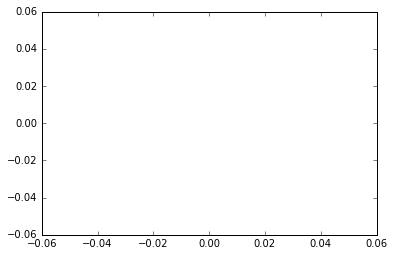

In [154]:
# Function to plot
plt.plot(list_ex)

In [155]:
def makeFig(): #Create a function that makes our desired plot
    plt.title('My Live Streaming Sensor Data')      #Plot the title
    plt.grid(True)                                  #Turn the grid on
    plt.ylabel('amplitud')                            #Set ylabels
    plt.plot(list_ex, label='time')       #plot the temperature
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [156]:
list_ex.append(0)
list_ex.append(0)
list_ex.append(0)
# Now, i need to actualize it every 200 points
for cnt,i in zip(range(400),s):
    list_ex.append(i)
    drawnow(makeFig)#Call drawnow to update our live graph
    plt.pause(.000001) #Pause Briefly. Important to keep drawnow from crashing
    if(cnt>50):                            #If you have 50 or more points, delete the first one from the array
        list_ex.pop(0)                       #This allows us to just see the last 200 data points

KeyboardInterrupt: 